# MLP 209
* Operate on 16000 GenCode 34 seqs.
* 5-way cross validation. Save best model per CV.
* Report mean accuracy from final re-validation with best 5.
* Use Adam with a learn rate decay schdule.

In [1]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
DATAPATH=""
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    NC_FILENAME = DATAPATH+NC_FILENAME
    PC_FILENAME = DATAPATH+PC_FILENAME
except:
    IN_COLAB = False
    DATAPATH="" 

EPOCHS=200
SPLITS=5
K=1
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
FILENAME='MLP209'
NEURONS=16 # see model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

## Build model

In [3]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    opt = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    model.compile(loss=bc, optimizer=opt, metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model(maxlen):
    act="elu"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(64, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation="sigmoid",dtype=dt)
    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    mlp.add(dense3_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

## Load and partition sequences

In [4]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)



## Make K-mers

In [5]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            #kmer=seq[i:i+2]+seq[i+3:i+5]    # SPACED SEED 2/1/2 for K=4
            kmer=seq[i:i+K]  
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [6]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # From pandas dataframe to numpy to list to numpy
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [7]:
def make_frequencies(Xin):
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

## Cross validation

In [8]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=DATAPATH+FILENAME+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [9]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=load_fasta(NC_FILENAME,0)
pc_seq=load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
print ("Compile the model")
model=build_model(MAXLEN)
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(DATAPATH+FILENAME+'.model')
print ("Data prep")
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train=make_frequencies(X_train)

Load data from files.
Ready: train_set
Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,713
Trainable params: 1,713
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: MLP209.model/assets
Data prep
D

Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5638 - accuracy: 0.7054 - val_loss: 0.5320 - val_accuracy: 0.7269
Epoch 2/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5513 - accuracy: 0.7175 - val_loss: 0.5336 - val_accuracy: 0.7312
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5480 - accuracy: 0.7186 - val_loss: 0.5353 - val_accuracy: 0.7232
Epoch 4/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5448 - accuracy: 0.7195 - val_loss: 0.5254 - val_accuracy: 0.7412
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5440 - accuracy: 0.7199 - val_loss: 0.5286 - val_accuracy: 0.7306
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5439 - accuracy: 0.7212 - val_loss: 0.5416 - val_accuracy: 0.7318
Epoch 7/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5441 - accuracy: 0.723

453/453 [==============================] - 1s 2ms/step - loss: 0.5295 - accuracy: 0.7310 - val_loss: 0.5239 - val_accuracy: 0.7337
Epoch 54/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5298 - accuracy: 0.7280 - val_loss: 0.5191 - val_accuracy: 0.7368
Epoch 55/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5296 - accuracy: 0.7294 - val_loss: 0.5276 - val_accuracy: 0.7368
Epoch 56/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5278 - accuracy: 0.7318 - val_loss: 0.5311 - val_accuracy: 0.7349
Epoch 57/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5283 - accuracy: 0.7305 - val_loss: 0.5172 - val_accuracy: 0.7474
Epoch 58/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5275 - accuracy: 0.7308 - val_loss: 0.5201 - val_accuracy: 0.7349
Epoch 59/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5283 - accuracy: 0.7312 - val_loss: 0.5155 - val_accuracy: 0.7498
Epoch

Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5240 - accuracy: 0.7357 - val_loss: 0.5277 - val_accuracy: 0.7393
Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5239 - accuracy: 0.7341 - val_loss: 0.5149 - val_accuracy: 0.7436
Epoch 110/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5241 - accuracy: 0.7337 - val_loss: 0.5160 - val_accuracy: 0.7505
Epoch 111/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5232 - accuracy: 0.7351 - val_loss: 0.5124 - val_accuracy: 0.7393
Epoch 112/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5248 - accuracy: 0.7336 - val_loss: 0.5219 - val_accuracy: 0.7430
Epoch 113/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5243 - accuracy: 0.7349 - val_loss: 0.5179 - val_accuracy: 0.7430
Epoch 114/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5239 - accuracy: 0.7332 - val_loss: 0.5141 - val_ac

453/453 [==============================] - 1s 2ms/step - loss: 0.5230 - accuracy: 0.7343 - val_loss: 0.5329 - val_accuracy: 0.7436
Epoch 165/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5233 - accuracy: 0.7346 - val_loss: 0.5202 - val_accuracy: 0.7436
Epoch 166/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5214 - accuracy: 0.7367 - val_loss: 0.5211 - val_accuracy: 0.7399
Epoch 167/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5242 - accuracy: 0.7350 - val_loss: 0.5199 - val_accuracy: 0.7436
Epoch 168/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5235 - accuracy: 0.7326 - val_loss: 0.5242 - val_accuracy: 0.7492
Epoch 169/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5209 - accuracy: 0.7356 - val_loss: 0.5203 - val_accuracy: 0.7349
Epoch 170/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5233 - accuracy: 0.7353 - val_loss: 0.5144 - val_accuracy: 0.7418

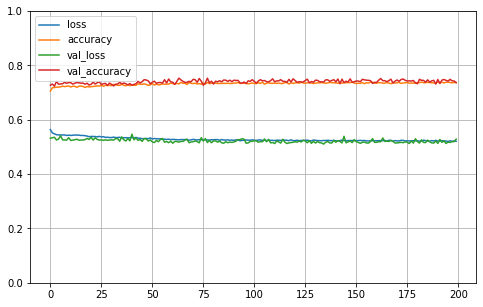

accuracy: 75.29%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5600 - accuracy: 0.7085 - val_loss: 0.5475 - val_accuracy: 0.7281
Epoch 2/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5482 - accuracy: 0.7189 - val_loss: 0.5494 - val_accuracy: 0.7318
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5456 - accuracy: 0.7218 - val_loss: 0.5436 - val_accuracy: 0.7306
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5431 - accuracy: 0.7236 - val_loss: 0.5450 - val_accuracy: 0.7250
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5448 - accuracy: 0.7226 - val_loss: 0.5518 - val_accuracy: 0.7250
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5435 - accuracy: 0.7203 - val_loss: 0.5455 - val_accuracy: 0.7207
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5431 - accuracy: 0.72

453/453 [==============================] - 1s 2ms/step - loss: 0.5283 - accuracy: 0.7317 - val_loss: 0.5371 - val_accuracy: 0.7387
Epoch 52/200
453/453 [==============================] - 2s 5ms/step - loss: 0.5284 - accuracy: 0.7306 - val_loss: 0.5376 - val_accuracy: 0.7443
Epoch 53/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5284 - accuracy: 0.7318 - val_loss: 0.5319 - val_accuracy: 0.7349
Epoch 54/200
453/453 [==============================] - 3s 6ms/step - loss: 0.5305 - accuracy: 0.7321 - val_loss: 0.5340 - val_accuracy: 0.7337
Epoch 55/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5290 - accuracy: 0.7310 - val_loss: 0.5300 - val_accuracy: 0.7399
Epoch 56/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5285 - accuracy: 0.7292 - val_loss: 0.5388 - val_accuracy: 0.7300
Epoch 57/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5297 - accuracy: 0.7288 - val_loss: 0.5296 - val_accuracy: 0.7436
Epoch

Epoch 105/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5263 - accuracy: 0.7343 - val_loss: 0.5291 - val_accuracy: 0.7412
Epoch 106/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5262 - accuracy: 0.7348 - val_loss: 0.5423 - val_accuracy: 0.7443
Epoch 107/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5240 - accuracy: 0.7355 - val_loss: 0.5366 - val_accuracy: 0.7368
Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5258 - accuracy: 0.7342 - val_loss: 0.5368 - val_accuracy: 0.7287
Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5248 - accuracy: 0.7358 - val_loss: 0.5336 - val_accuracy: 0.7461
Epoch 110/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5240 - accuracy: 0.7346 - val_loss: 0.5282 - val_accuracy: 0.7424
Epoch 111/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5246 - accuracy: 0.7342 - val_loss: 0.5305 - val_ac

453/453 [==============================] - 1s 2ms/step - loss: 0.5223 - accuracy: 0.7348 - val_loss: 0.5301 - val_accuracy: 0.7436
Epoch 159/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5218 - accuracy: 0.7354 - val_loss: 0.5383 - val_accuracy: 0.7436
Epoch 160/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5223 - accuracy: 0.7380 - val_loss: 0.5314 - val_accuracy: 0.7356
Epoch 161/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5218 - accuracy: 0.7364 - val_loss: 0.5312 - val_accuracy: 0.7405
Epoch 162/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5224 - accuracy: 0.7349 - val_loss: 0.5287 - val_accuracy: 0.7374
Epoch 163/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5221 - accuracy: 0.7316 - val_loss: 0.5377 - val_accuracy: 0.7399
Epoch 164/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5219 - accuracy: 0.7382 - val_loss: 0.5283 - val_accuracy: 0.7449

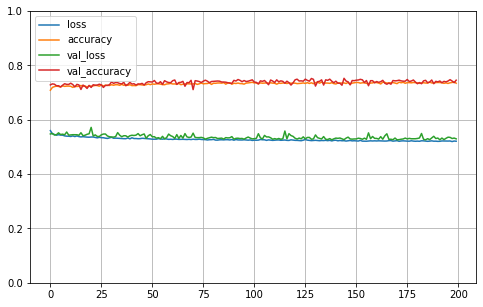

accuracy: 75.23%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5584 - accuracy: 0.7090 - val_loss: 0.5419 - val_accuracy: 0.7232
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5473 - accuracy: 0.7203 - val_loss: 0.5322 - val_accuracy: 0.7337
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5474 - accuracy: 0.7195 - val_loss: 0.5326 - val_accuracy: 0.7331
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5462 - accuracy: 0.7185 - val_loss: 0.5464 - val_accuracy: 0.7244
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5435 - accuracy: 0.7208 - val_loss: 0.5420 - val_accuracy: 0.7325
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5454 - accuracy: 0.7154 - val_loss: 0.5384 - val_accuracy: 0.7331
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5426 - accuracy: 0.72

Epoch 50/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5300 - accuracy: 0.7306 - val_loss: 0.5291 - val_accuracy: 0.7325
Epoch 51/200
453/453 [==============================] - 3s 7ms/step - loss: 0.5307 - accuracy: 0.7306 - val_loss: 0.5316 - val_accuracy: 0.7412
Epoch 52/200
453/453 [==============================] - 2s 5ms/step - loss: 0.5311 - accuracy: 0.7295 - val_loss: 0.5289 - val_accuracy: 0.7269
Epoch 53/200
453/453 [==============================] - 2s 5ms/step - loss: 0.5305 - accuracy: 0.7294 - val_loss: 0.5335 - val_accuracy: 0.7325
Epoch 54/200
453/453 [==============================] - 3s 6ms/step - loss: 0.5295 - accuracy: 0.7313 - val_loss: 0.5274 - val_accuracy: 0.7381
Epoch 55/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5299 - accuracy: 0.7316 - val_loss: 0.5276 - val_accuracy: 0.7349
Epoch 56/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5286 - accuracy: 0.7288 - val_loss: 0.5345 - val_accuracy:

453/453 [==============================] - 1s 3ms/step - loss: 0.5229 - accuracy: 0.7360 - val_loss: 0.5252 - val_accuracy: 0.7349
Epoch 104/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5255 - accuracy: 0.7315 - val_loss: 0.5285 - val_accuracy: 0.7312
Epoch 105/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5243 - accuracy: 0.7333 - val_loss: 0.5261 - val_accuracy: 0.7412
Epoch 106/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5242 - accuracy: 0.7333 - val_loss: 0.5192 - val_accuracy: 0.7412
Epoch 107/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5242 - accuracy: 0.7369 - val_loss: 0.5283 - val_accuracy: 0.7300
Epoch 108/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5221 - accuracy: 0.7357 - val_loss: 0.5264 - val_accuracy: 0.7405
Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5239 - accuracy: 0.7369 - val_loss: 0.5218 - val_accuracy: 0.7343

453/453 [==============================] - 1s 2ms/step - loss: 0.5217 - accuracy: 0.7363 - val_loss: 0.5277 - val_accuracy: 0.7368
Epoch 159/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5201 - accuracy: 0.7351 - val_loss: 0.5197 - val_accuracy: 0.7374
Epoch 160/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5201 - accuracy: 0.7387 - val_loss: 0.5226 - val_accuracy: 0.7424
Epoch 161/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5197 - accuracy: 0.7351 - val_loss: 0.5233 - val_accuracy: 0.7269
Epoch 162/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5200 - accuracy: 0.7330 - val_loss: 0.5250 - val_accuracy: 0.7405
Epoch 163/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5206 - accuracy: 0.7366 - val_loss: 0.5203 - val_accuracy: 0.7430
Epoch 164/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5224 - accuracy: 0.7352 - val_loss: 0.5210 - val_accuracy: 0.7381

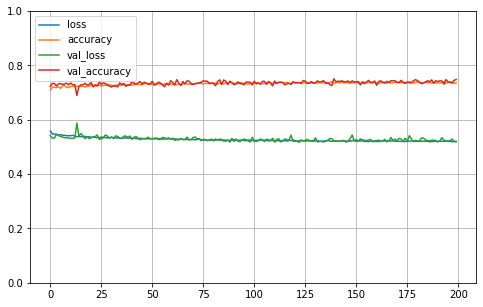

accuracy: 75.05%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5588 - accuracy: 0.7115 - val_loss: 0.5332 - val_accuracy: 0.7368
Epoch 2/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5501 - accuracy: 0.7188 - val_loss: 0.5560 - val_accuracy: 0.7207
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5495 - accuracy: 0.7181 - val_loss: 0.5562 - val_accuracy: 0.7269
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5455 - accuracy: 0.7195 - val_loss: 0.5410 - val_accuracy: 0.7200
Epoch 5/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5453 - accuracy: 0.7213 - val_loss: 0.5279 - val_accuracy: 0.7374
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5447 - accuracy: 0.7215 - val_loss: 0.5406 - val_accuracy: 0.7287
Epoch 7/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5460 - accuracy: 0.72

Epoch 52/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5328 - accuracy: 0.7275 - val_loss: 0.5286 - val_accuracy: 0.7256
Epoch 53/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5325 - accuracy: 0.7275 - val_loss: 0.5209 - val_accuracy: 0.7412
Epoch 54/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5334 - accuracy: 0.7290 - val_loss: 0.5236 - val_accuracy: 0.7356
Epoch 55/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5320 - accuracy: 0.7324 - val_loss: 0.5312 - val_accuracy: 0.7374
Epoch 56/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5326 - accuracy: 0.7290 - val_loss: 0.5280 - val_accuracy: 0.7318
Epoch 57/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5321 - accuracy: 0.7275 - val_loss: 0.5207 - val_accuracy: 0.7393
Epoch 58/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5329 - accuracy: 0.7294 - val_loss: 0.5334 - val_accuracy:

Epoch 107/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5274 - accuracy: 0.7350 - val_loss: 0.5198 - val_accuracy: 0.7331
Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5273 - accuracy: 0.7339 - val_loss: 0.5210 - val_accuracy: 0.7349
Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5278 - accuracy: 0.7332 - val_loss: 0.5202 - val_accuracy: 0.7368
Epoch 110/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5279 - accuracy: 0.7327 - val_loss: 0.5266 - val_accuracy: 0.7318
Epoch 111/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5267 - accuracy: 0.7357 - val_loss: 0.5172 - val_accuracy: 0.7412
Epoch 112/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5269 - accuracy: 0.7350 - val_loss: 0.5278 - val_accuracy: 0.7331
Epoch 113/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5274 - accuracy: 0.7315 - val_loss: 0.5162 - val_ac

453/453 [==============================] - 1s 2ms/step - loss: 0.5246 - accuracy: 0.7341 - val_loss: 0.5203 - val_accuracy: 0.7387
Epoch 163/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5252 - accuracy: 0.7357 - val_loss: 0.5288 - val_accuracy: 0.7356
Epoch 164/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5254 - accuracy: 0.7352 - val_loss: 0.5152 - val_accuracy: 0.7424
Epoch 165/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5262 - accuracy: 0.7335 - val_loss: 0.5228 - val_accuracy: 0.7405
Epoch 166/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5265 - accuracy: 0.7356 - val_loss: 0.5211 - val_accuracy: 0.7418
Epoch 167/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5248 - accuracy: 0.7358 - val_loss: 0.5228 - val_accuracy: 0.7443
Epoch 168/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5243 - accuracy: 0.7386 - val_loss: 0.5194 - val_accuracy: 0.7418

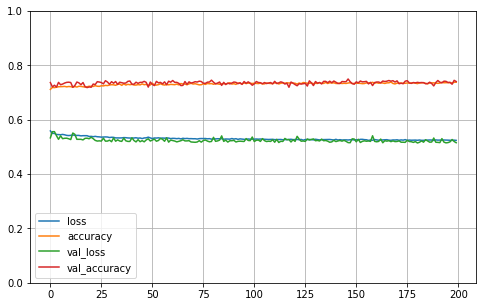

accuracy: 74.98%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 5ms/step - loss: 0.5621 - accuracy: 0.7101 - val_loss: 0.5590 - val_accuracy: 0.7163
Epoch 2/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5486 - accuracy: 0.7160 - val_loss: 0.5448 - val_accuracy: 0.7306
Epoch 3/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5481 - accuracy: 0.7195 - val_loss: 0.5334 - val_accuracy: 0.7349
Epoch 4/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5454 - accuracy: 0.7216 - val_loss: 0.5311 - val_accuracy: 0.7362
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5440 - accuracy: 0.7203 - val_loss: 0.5638 - val_accuracy: 0.6940
Epoch 6/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5450 - accuracy: 0.7201 - val_loss: 0.5302 - val_accuracy: 0.7374
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5445 - accuracy: 0.71

Epoch 50/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5350 - accuracy: 0.7237 - val_loss: 0.5275 - val_accuracy: 0.7337
Epoch 51/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5361 - accuracy: 0.7227 - val_loss: 0.5237 - val_accuracy: 0.7349
Epoch 52/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5362 - accuracy: 0.7233 - val_loss: 0.5273 - val_accuracy: 0.7269
Epoch 53/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5341 - accuracy: 0.7258 - val_loss: 0.5283 - val_accuracy: 0.7349
Epoch 54/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5354 - accuracy: 0.7248 - val_loss: 0.5287 - val_accuracy: 0.7343
Epoch 55/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5344 - accuracy: 0.7224 - val_loss: 0.5242 - val_accuracy: 0.7393
Epoch 56/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5341 - accuracy: 0.7217 - val_loss: 0.5294 - val_accuracy:

453/453 [==============================] - 1s 3ms/step - loss: 0.5293 - accuracy: 0.7312 - val_loss: 0.5238 - val_accuracy: 0.7443
Epoch 101/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5299 - accuracy: 0.7328 - val_loss: 0.5355 - val_accuracy: 0.7343
Epoch 102/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5295 - accuracy: 0.7303 - val_loss: 0.5306 - val_accuracy: 0.7424
Epoch 103/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5276 - accuracy: 0.7341 - val_loss: 0.5215 - val_accuracy: 0.7486
Epoch 104/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5282 - accuracy: 0.7314 - val_loss: 0.5284 - val_accuracy: 0.7275
Epoch 105/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5272 - accuracy: 0.7316 - val_loss: 0.5284 - val_accuracy: 0.7461
Epoch 106/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5280 - accuracy: 0.7310 - val_loss: 0.5181 - val_accuracy: 0.7511

453/453 [==============================] - 1s 2ms/step - loss: 0.5255 - accuracy: 0.7348 - val_loss: 0.5154 - val_accuracy: 0.7505
Epoch 157/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5242 - accuracy: 0.7351 - val_loss: 0.5209 - val_accuracy: 0.7393
Epoch 158/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5250 - accuracy: 0.7342 - val_loss: 0.5158 - val_accuracy: 0.7461
Epoch 159/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5244 - accuracy: 0.7332 - val_loss: 0.5194 - val_accuracy: 0.7486
Epoch 160/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5253 - accuracy: 0.7358 - val_loss: 0.5136 - val_accuracy: 0.7492
Epoch 161/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5238 - accuracy: 0.7350 - val_loss: 0.5194 - val_accuracy: 0.7467
Epoch 162/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5245 - accuracy: 0.7369 - val_loss: 0.5156 - val_accuracy: 0.7412

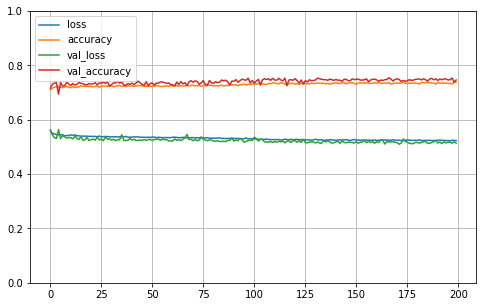

accuracy: 75.42%

5-way Cross Validation mean 75.20% (+/- 0.16%)
Done


In [10]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")